# Dimensionality reduction
Functions to get numeric data, transform it and plot

In [18]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
%run 82_label_modifying.ipynb

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
def find_diff(df):
    """
    Find number of rows for metainformation in df. This rows should located at the bottom of df
    Assumes that only peak names contains numbers
    Used for finding constant meta
    :param df: df - dataframe with metadata
    :return: int - number of rows which are taken by metadata
    """
    meta = df.shape[0] - df.filter(regex=r'\d+', axis=0).index.shape[0]
    return meta

In [21]:
def reduce_dimensions(df, analysis, species, separation_feature, functions, included_variants, excluded_variants={}, with_mass=True):
    """
    Top function to perform dimensionality reduction, plot graph and save figure
    :param df: df - dataframe merged with metadata
    :param analysis: str - lowercase name of analysis, e.g. pca or mds
    :param species: str - name of species
    :param separation_feature: str - name of feature which will be separated on plot by color, e.g. tissue or age
    :param functions: dict - dictionary with name: transformation_function
    :param included_variants: dict - dictionary with selected feature: variant for analysis
    :param excluded_variants: dict - dictionary with excluded feature: variant from analysis
    :param with_mass: bool - whether to take samples without mass in the analysis
    :return:
    """
    # Create title
    title = construct_title(analysis, species, included_variants, separation_feature, with_mass)

    # Take appropriate subset of data
    ss = subset(df, included_variants, excluded_variants, with_mass=with_mass)
        
    # Exit function if subset is empty
    if ss.empty or ss.loc[separation_feature].isna().all():
        return

    # Extract y and classes for plot
    y, classes = extract_data_for_plot(ss, separation_feature)

    # Transform selected samples with PCA or MDS or something else
    transforming(analysis, functions, ss, title, y, classes)

In [22]:
def draw_for_all(df, feature, analysis, species, separation_feature, functions, excluded_variants={}, with_mass=True):
    """
    Draw and save plots for analysis of everything feature variant separately
    Plots for subsets of data where variants for separation_feature are absent (NA) won't be drawed
    :param df: df - dataframe merged with metadata
    :param feature: str - index of df row which contains variants which should be plotted separately
    :param analysis: str - lowercase name of analysis, e.g. pca or mds
    :param species: str - name of species
    :param separation_feature: str - name of feature which will be separated on plot by color, e.g. tissue or age
    :param functions: dict - dictionary with name: transformation_function
    :param excluded_variants: dict - dictionary with excluded feature: variant from analysis
    :param with_mass: bool - whether to take samples without mass in the analysis
    :return:
    """
    # Select non NA variants
    variants = df.loc[feature].unique()
    nas = pd.isna(variants)

    # Draw and save plot for each subset of data with particular value of feature 
    for variant in variants[~nas]:
        included_variants = {feature: variant}
        reduce_dimensions(df, analysis, species, separation_feature, functions, included_variants, excluded_variants,
                          with_mass)

In [23]:
def transforming(analysis, functions, ss, title, y, classes):
    """
    Perform appropriate transformation and plotting, save figure
    :param analysis: str - name of analysis, e.g. pca or mds
    :param functions: dict - dictionary with name: transformation_function 
    :param ss: df - chosen subset of data 
    :param title: str - title of plot and name of file
    :param y: sequence - collection of observation labels e.g. old/young for age, bones/blood for tiessue etc.
    :param classes: sequence - container with unique labels of observations
    :return: 
    """
    if analysis == 'pca':
        transformed, (var1, var2) = functions[analysis](ss)
        # Draw and save plot
        draw_dimensionality_reduction(title, transformed, y, classes, title=title, var1=var1, var2=var2)
    else:
        transformed = functions[analysis](ss)
        # Draw and save plot
        draw_dimensionality_reduction(title, transformed, y, classes, title=title)

In [24]:
def subset(df, include, exclude={}, with_mass=True):
    """
    Take appropriate slice of data, use samples_with_mass constant which should be predefined. 
    At least one of include and exclude should be provided, could be both
    :param df: df - dataframe merged with metadata
    :param include: dict - dictionary with feature: variant to include variant of feature from output df
                           other appropriate format is feature: [variants] to include all listed variants
    :param exclude: dict - dictionary with feature: variant to exclude variant of feature from output df
                           other appropriate format is feature: [variants] to exclude all listed variants
    :param with_mass: boolean - whether to exclude samples without known mass,
                                idk why I have included this option - it always should be True
    :return: df - subset of input df
    """
    # Create a copy of original df
    df = df.copy()
    # Initialize condition with neutral element
    cond = True

    # For features in include add to condition appropriate columns
    for feature, variant in include.items():
        # Add single variant
        if type(variant) is str:
            cond &= (df.loc[feature] == variant)
        # Add several variants
        else:
            cond &= df.loc[feature].isin(variant)
    
    # For features in include add to condition appropriate columns
    for feature, variant in exclude.items():
            # Remove single variant
            if type(variant) is str:
                cond &= (df.loc[feature] != variant)
            # Remove several variants
            else:
                cond &= ~df.loc[feature].isin(variant)
    
    # Imho this condition is always true, hence with_mass parameter should be removed
    # Take only columns with present mass
    if with_mass:
        return df.loc[:, cond & samples_with_mass]
    # Take all selected columns
    return df.loc[:, cond]

In [25]:
def extract_data_for_plot(df, sample_feature):
    """
    Take label series of data and all unique possible variants of this label type
    :param df: df - part of samples from dataframe merged with metadata
    :param sample_feature: str - index of row containing variants by which samples will be divided on the plot
    :return: (series, array) - tuple with row of given feature from input array and array with unique values in this
                               series
    """
    # Take series
    y = df.loc[sample_feature]
    # Take unique variants
    classes = df.loc[sample_feature].unique()
    return y, classes

In [26]:
def pca_transform(df, n_components=2):
    """
    Transform data for PCA
    meta constant should be predefined
    :param df: df - subset of dataframe merged with metadata
    :param n_components: int - number of components
    :return: array - np array with number of samples x n_components shape 
    """
    # Initialize transformer
    pca = PCA(n_components=n_components)
    # Take numeric subset of data and
    # Transpose df, because as we love in ml ROWS are observations and COLUMNS are features and
    # all normal functions follow this convention. Thus we finally transpose df to normal form
    transformed = pca.fit_transform(df.iloc[:-meta].T)

    # Get info about variance percentages
    variance = pca.explained_variance_ratio_
    return transformed, tuple(map(lambda x: np.round(x, 2), variance))

In [27]:
def mds_transform(df, n_components=2):
    """
    Transform data for MDS, meta constant should be predefined
    :param df: df - subset of dataframe merged with metadata
    :param n_components: int - number of components
    :return: array - np array with number of samples x n_components shape
    """
    # Initialize transformer
    mds = MDS(n_components=n_components, n_jobs=-1)
    # Take numeric subset of data and
    # Transpose df, because as we love in ml ROWS are observations and COLUMNS are features and
    # all normal functions follow this convention. Thus we finally transpose df to normal form
    transformed = mds.fit_transform(df.iloc[:-meta].T)
    return transformed

In [28]:
def draw_dimensionality_reduction(name, transformed, y, classes, colors=None, title='PCA', var1=0, var2=0, locus='best'):
    """
    Plot results of dimensionality collapsing
    :param name: str - name of saved figure
    :param transformed: array - 2d array with transformed data
    :param y: sequence - collection of observation labels e.g. old/young for age, bones/blood for tiessue etc.
    :param classes: sequence - container with unique labels of observations
    :param colors: sequence - container with colors in #HHHHHH format where H is a hex digit
    :param title: str - title of figure
    :param var1: float - portion of explained variance by PC1
    :param var2: float - portion of explained variance by PC1
    :param locus: str - position of legend
    :return:
    """
    # Specify plot size
    plt.figure(figsize=(12, 8))

    # Use specified colors if provided
    if colors:
        for sp, color in zip(classes, colors):
            plt.scatter(transformed[sp == y, 0],
                        transformed[sp == y, 1],
                        alpha=0.8, color=color, label=sp)
    else:
        for sp in classes:
            plt.scatter(transformed[sp == y, 0],
                        transformed[sp == y, 1],
                        alpha=0.8, label=sp)

    # Metadata
    # For pca plot add axis labels with explained variance portion
    if 'PCA' in title:
        xlab = f'PC1, {var1}'
        ylab = f'PC2, {var2}'
        plt.xlabel(xlab)
        plt.ylabel(ylab)


    plt.legend(loc=locus, shadow=False)
    plt.title(title)
    
    # Create dir for images and save svg image
    os.makedirs('img', exist_ok=True)
    plt.savefig(f'img/{name}.svg', format='svg', bbox_inches='tight')

In [29]:
def construct_title(analysis, species, included_variants, separation_feature, with_mass):
    """
    Construct title for plot by inferring key features of samples in dataset
    :param analysis: str - name of analysis, e.g. pca or MDS
    :param species: str - name of species, e.g. H. sapiens or rats
    :param included_variants: dict - dictionary with selected feature: variant for analysis
    :param separation_feature: str - name of feature which will be separated on plot by color, e.g. tissue or age
    :return: str - title
    """
    # Initialize variable for singleton features which contains only one variant
    features = []

    # Collect features which have only 1 variant into features
    for feature, variable in included_variants.items():
        if isinstance(variable, str):
            features.append(variable)
        elif len(variable) == 1:
            features.append(variable[0])
    
    # Create mass part
    if with_mass:
        wm = 'only with mass'
    else:
        wm = 'with and without mass'
    
    # Construct title
    title = f'{analysis.upper()} of {", ".join(features)} {species.capitalize()} {wm} separated by {separation_feature.lower()}'
    return title

## Example of usage with drawing PCA
There is quite a big number of variables which should be predefined for analysis

In [31]:
# Load data
name = 'normalized_with_meta_log_transformed_substituted_NA_cleaned_control_cleaned_isotopes_cleaned_contaminants_xs_annotated_rats_neg.csv'
df = pd.read_csv(name, index_col=0)

# Preliminaries
# Whether samples contain mass
samples_with_mass = ~df.loc['mass', samples].isna()
# Find number of rows with metadata in df
meta = find_diff(df)

# Dict with name: function of transformation functions
functions = {'pca': pca_transform, 'mds': mds_transform}

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# Specify analysis name and species for selecting transformation and constructing title
analysis = 'pca'
species = 'rats'

# Specify included or excluded variants or both (seems like 1 of them is usually enough)
included_variants = {'age': 'old_1', 'tissue': ['brain_pfc', 'brain_cb', 'plasma']}
excluded_variants = {'tissue': ['liver', 'muscle']}

# Specify feature which will be used for differentiation of samples on the plot (different color)
separation_feature = 'tissue'

# Plotting
reduce_dimensions(df, analysis, species, separation_feature, functions, included_variants, excluded_variants, with_mass=False)

Empty DataFrame
Columns: []
Index: [19, 1855, 1920, 1928, 1962, 1970, 1987, 2060, 2231, 2272, 423, 2281, 2295, 2324, 2372, 2375, 2504, 2537, 2609, 2650, 2665, 2723, 2739, 2741, 486, 2770, 2771, 2825, 2830, 2858, 2859, 2875, 2881, 2969, 3014, 596, 3127, 3219, 3228, 3233, 3244, 3256, 3272, 3352, 3372, 3507, 3527, 3625, 3640, 3663, 36, 3692, 3699, 3747, 3818, 3822, 3827, 3854, 3884, 3908, 4014, 4033, 4046, 4052, 4073, 4074, 657, 4080, 4087, 4110, 4121, 4154, 4189, 4205, 4280, 4478, 4502, 4557, 4581, 4601, 4646, 4685, 4694, 4702, 4724, 4758, 4829, 4846, 4890, 4917, 4928, 4930, 741, 5016, 5035, 5147, 5235, 5255, 5285, 758, ...]

[4237 rows x 0 columns]


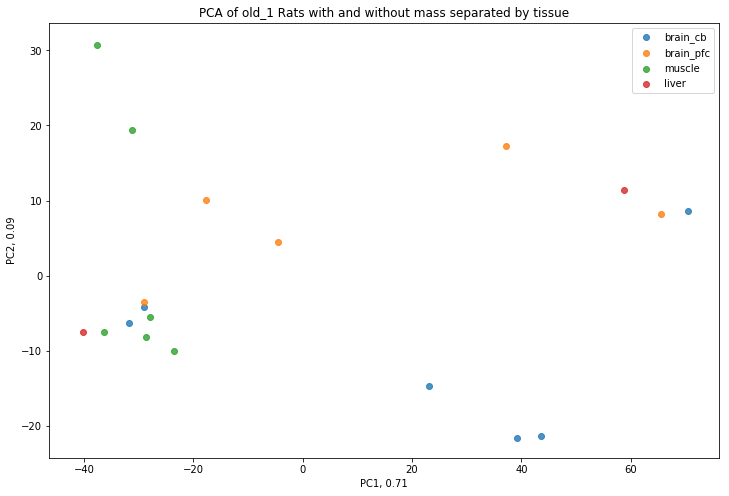

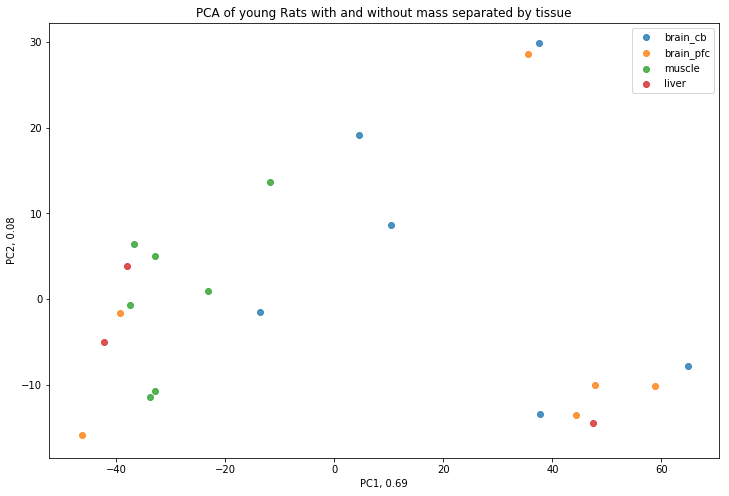

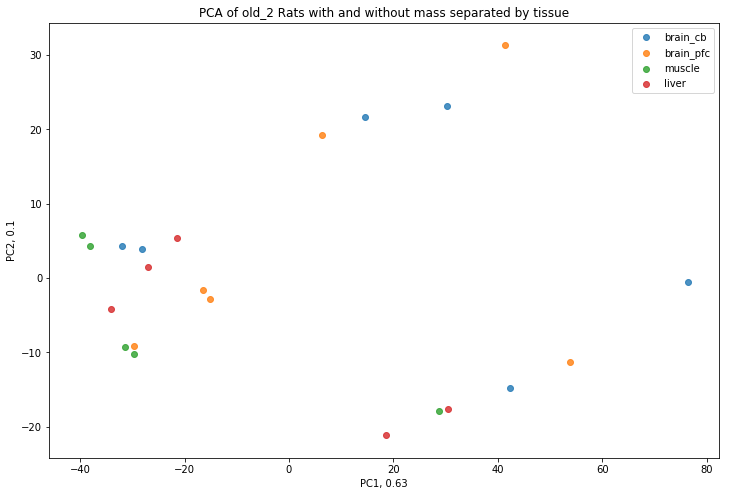

In [32]:
draw_for_all(df, 'age', 'pca', 'rats', 'tissue', functions, {'tissue': 'plasma'}, with_mass=False)

## Draw PCA and MDS of each tissue for all ages

In [103]:
s = np.zeros((3, 3))
s[(0, 0)] = 1

In [137]:
pp

array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [139]:
pp = np.argwhere(s == 0)

In [161]:
np.random.choice(range(9))

7

In [163]:
range(9)

range(0, 9)

In [155]:
np.random.choice(range(10), 10)

array([2, 6, 2, 8, 9, 9, 6, 4, 2, 5])

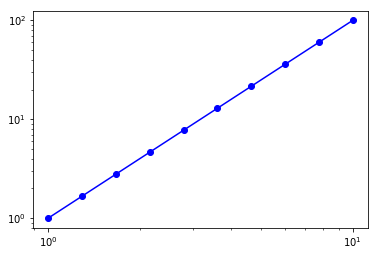

In [156]:
x=np.logspace(0,1,10)
y=x**2
plt.loglog(x,y,"bo-") 

In [105]:
feature, analysis, species, separation_feature

('age', 'pca', 'rats', 'tissue')

In [ ]:
reduce_dimensions

In [ ]:
# Change this name seriously
# And rename draw_for_all
def plots_plots(df, analyses=('pca', 'mds'), separations=['tissue', 'age']):
    # Plot figure for each specified analysis with and without mass for each feature in separations divided by the other feature
    for analysis in analyses:
        for with_mass in [True, False]:
            # 1 feature separated by other and vice versa
            draw_for_all(df, separations[0], analysis, species, separations[1], functions, {}, with_mass=with_mass)
            draw_for_all(df, separations[1], analysis, species, separations[0], functions, {}, with_mass=with_mass)

/home/arleg/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


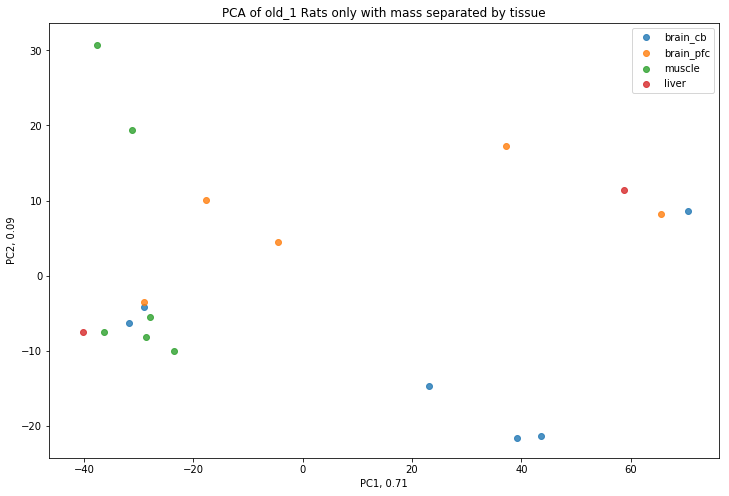

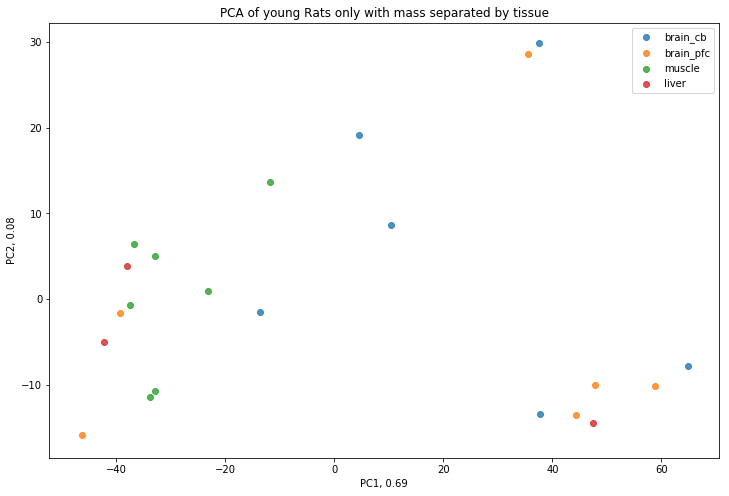

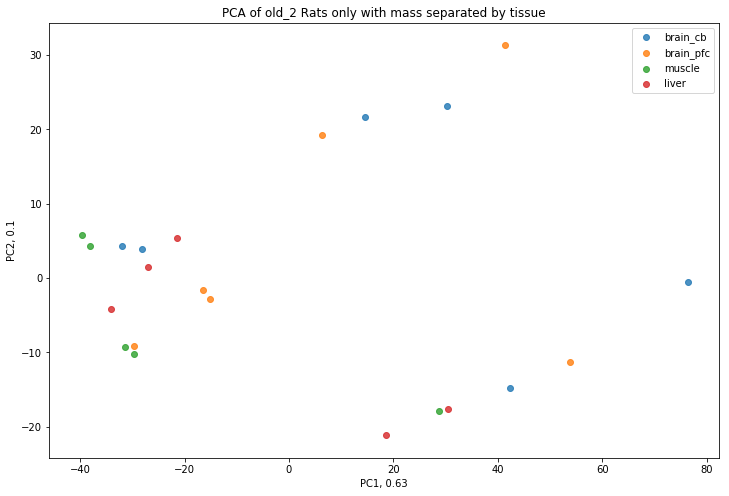

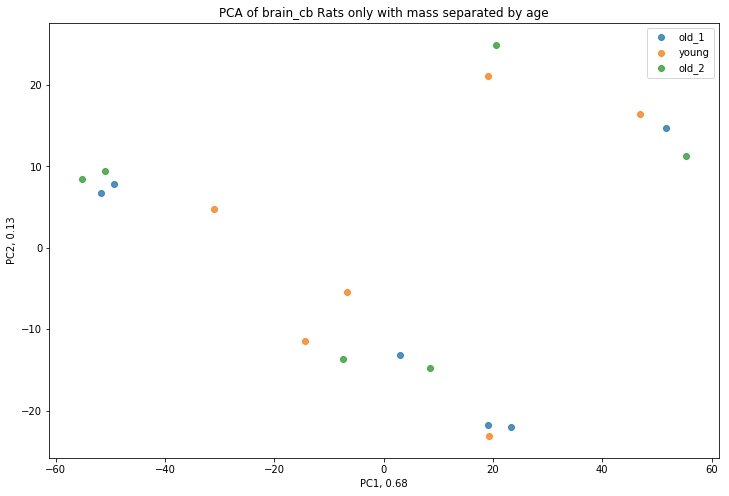

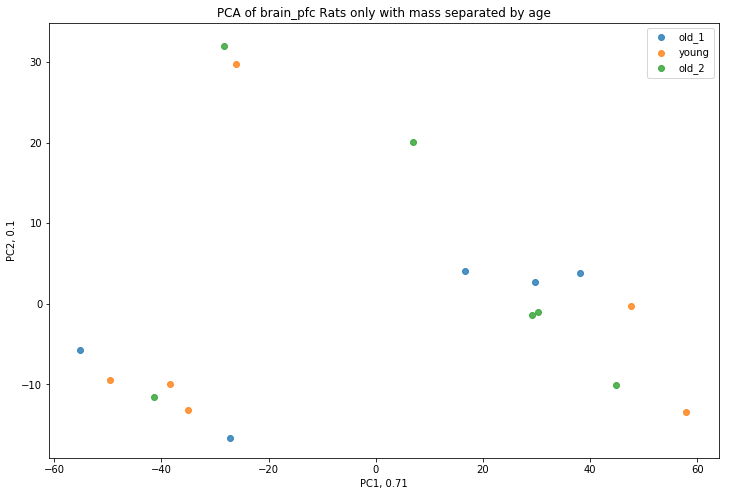

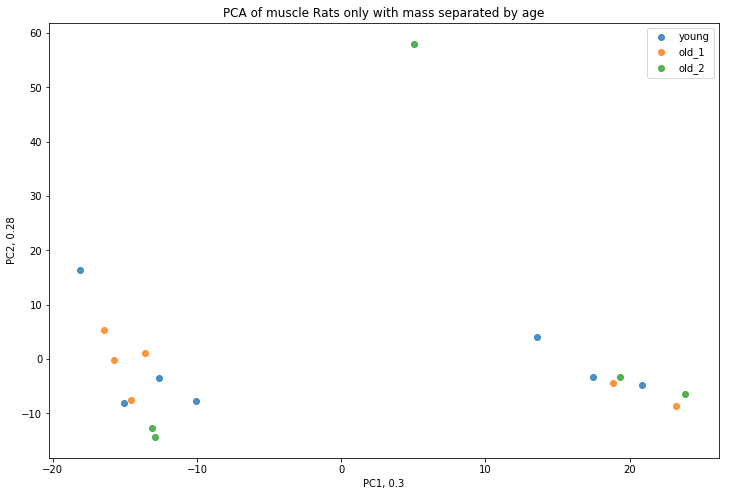

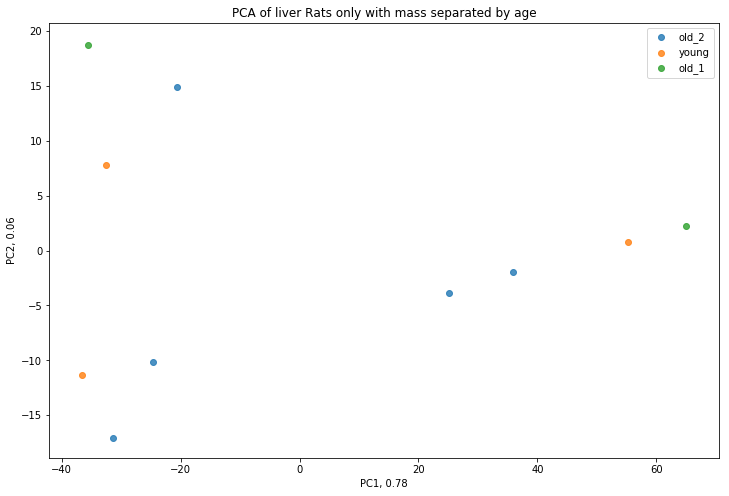

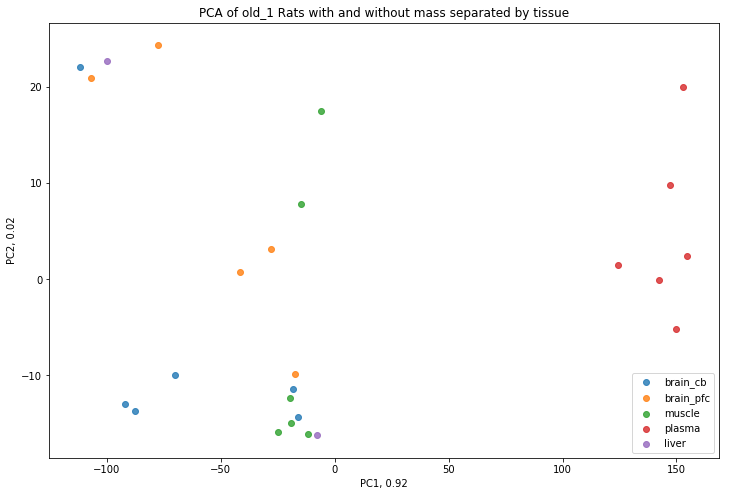

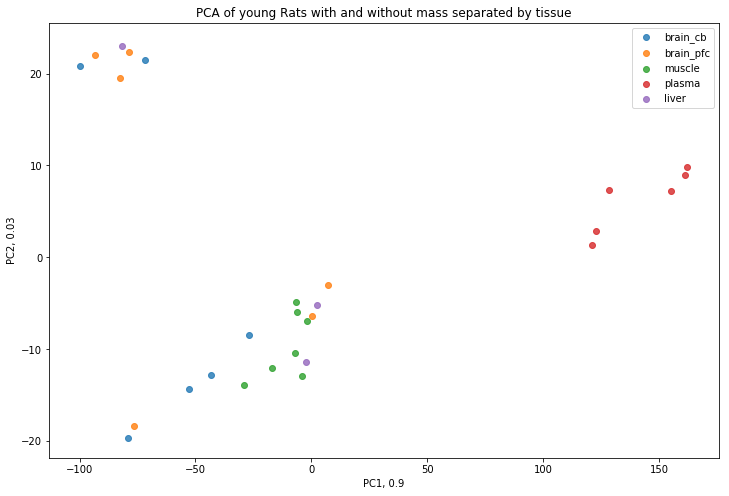

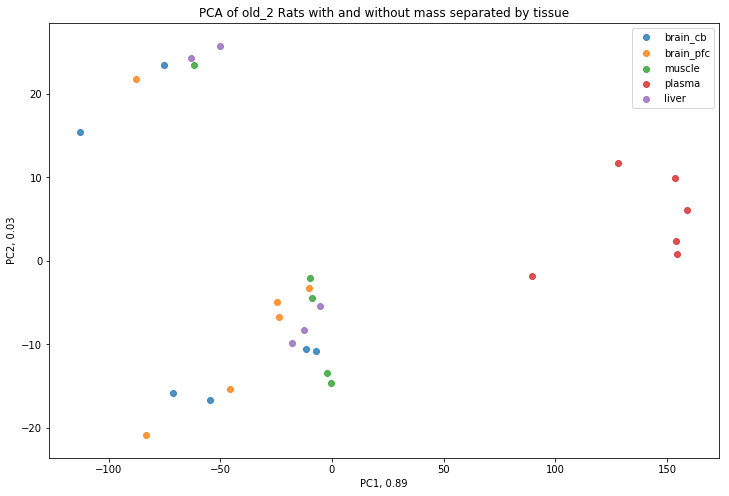

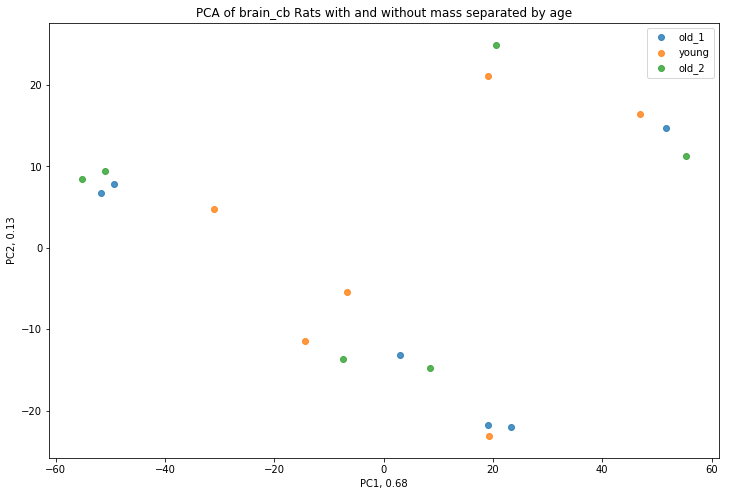

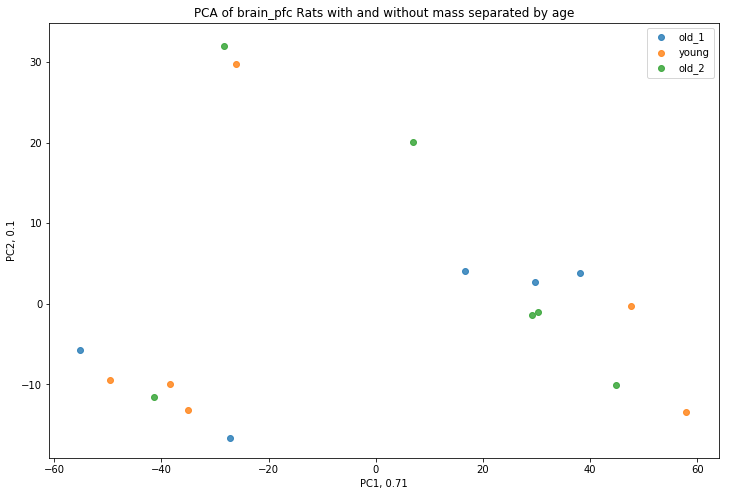

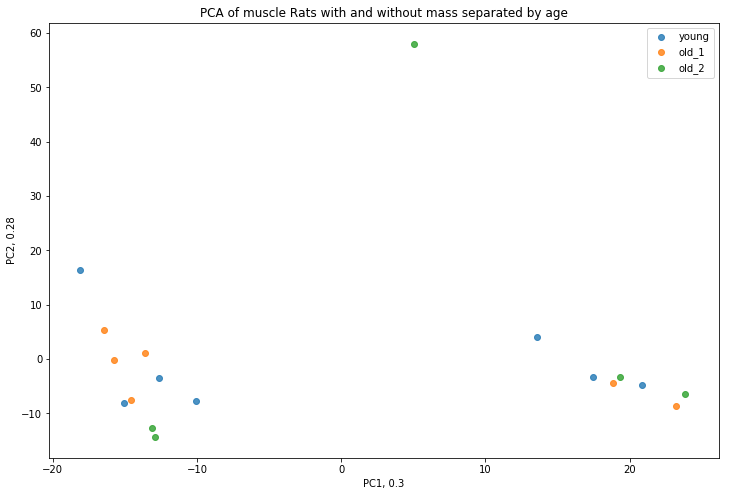

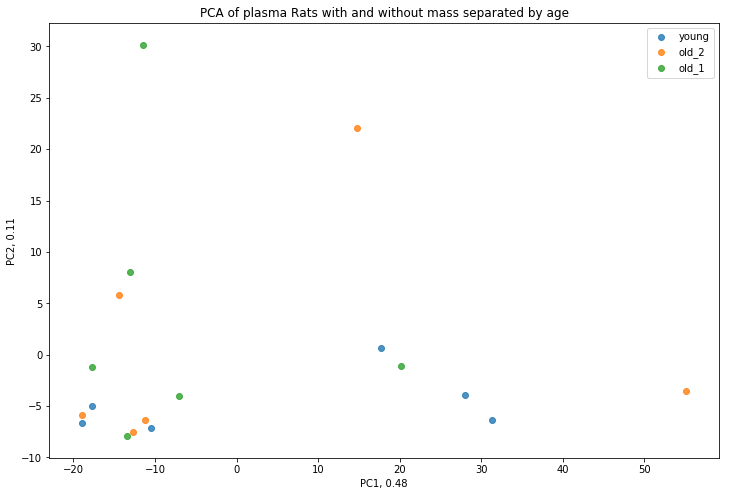

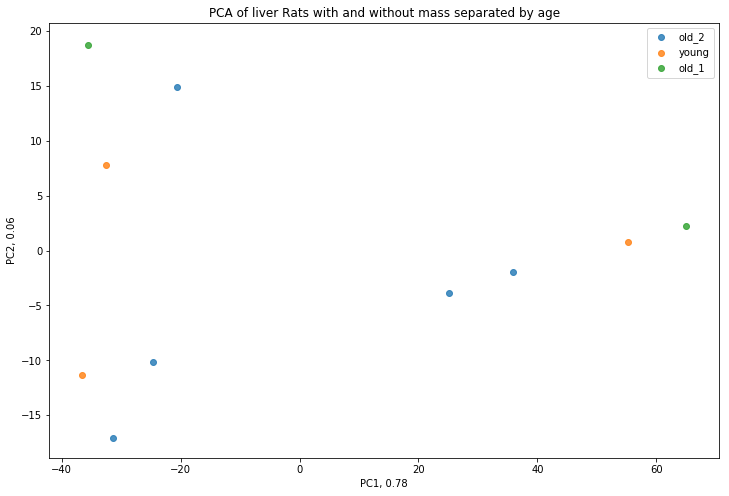

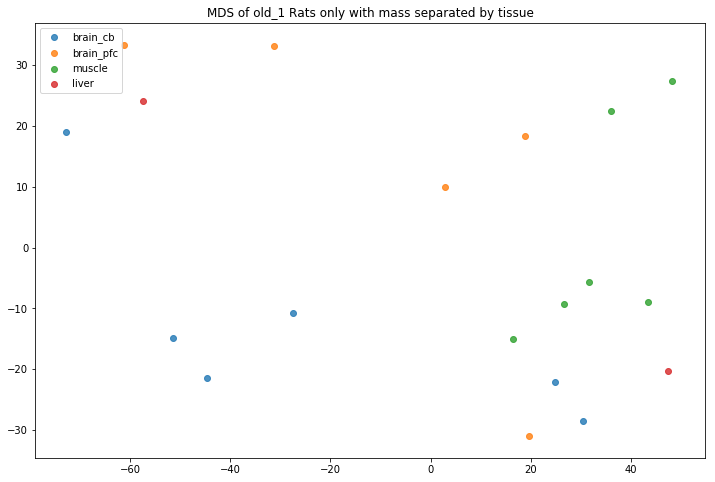

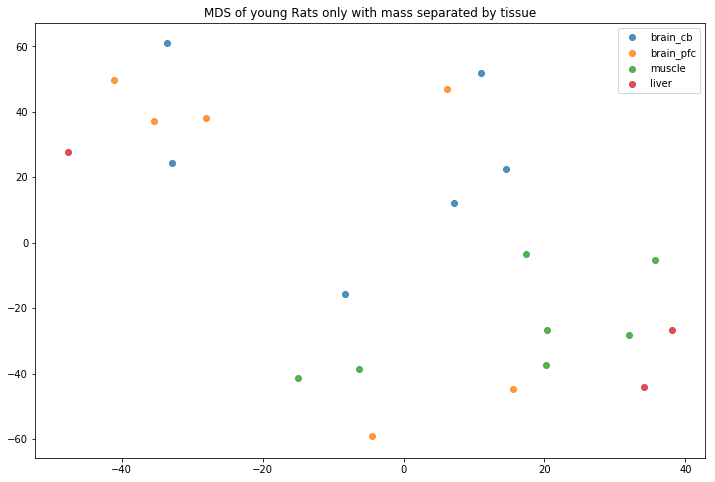

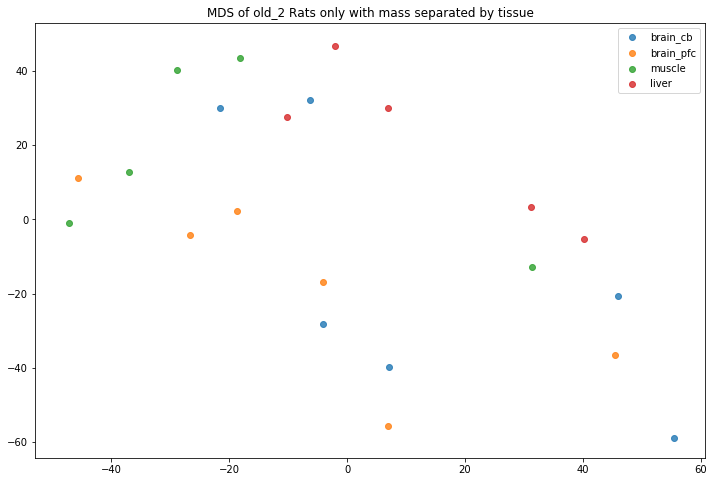

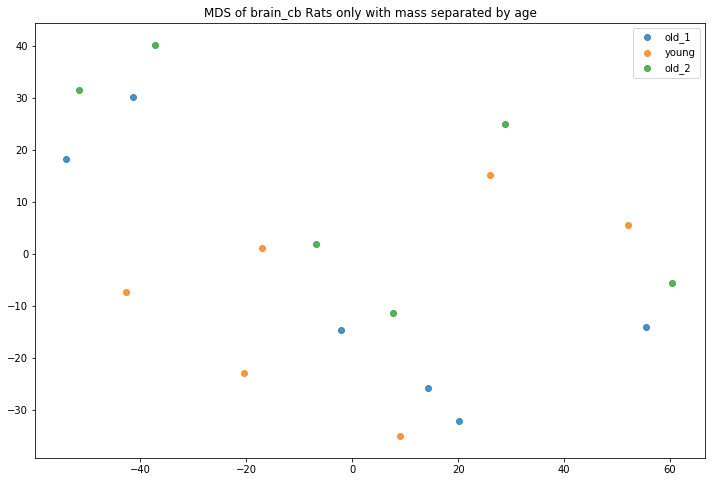

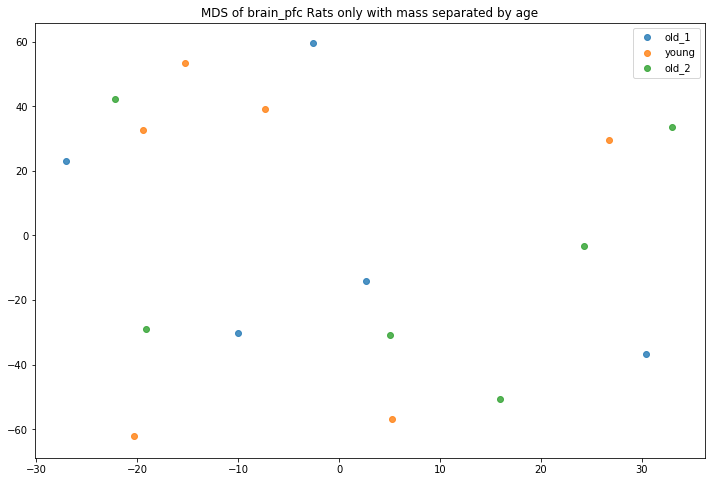

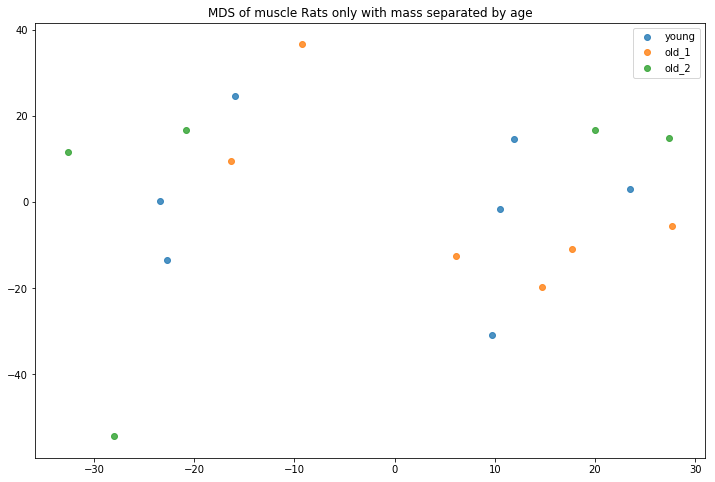

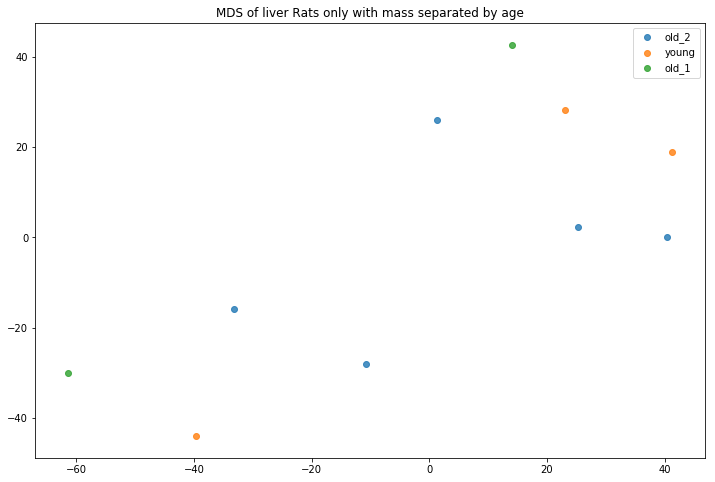

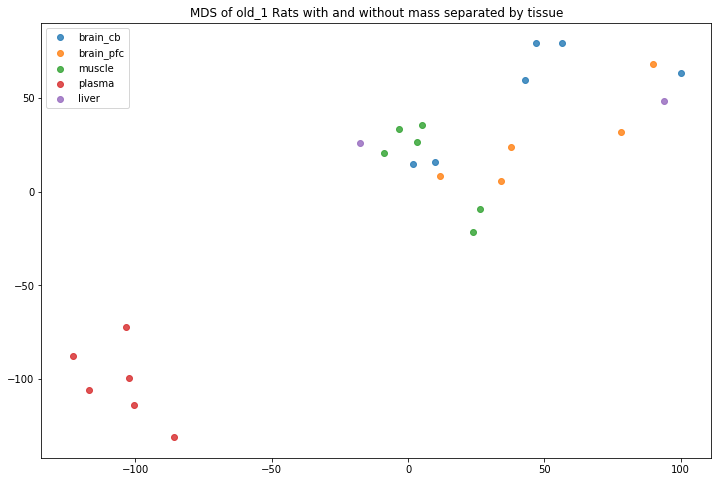

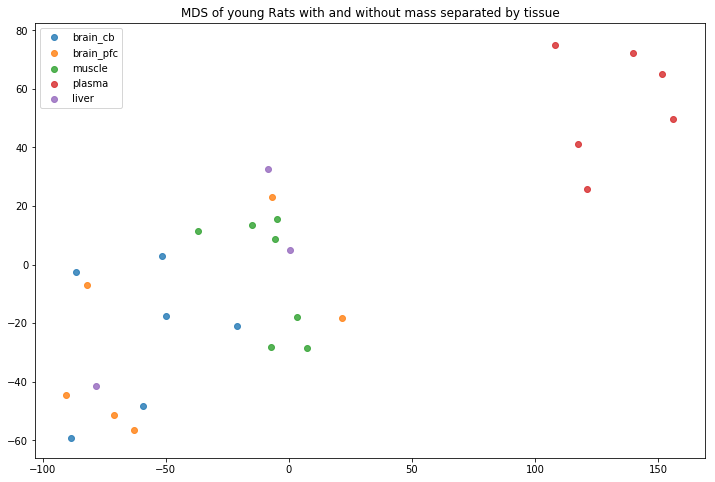

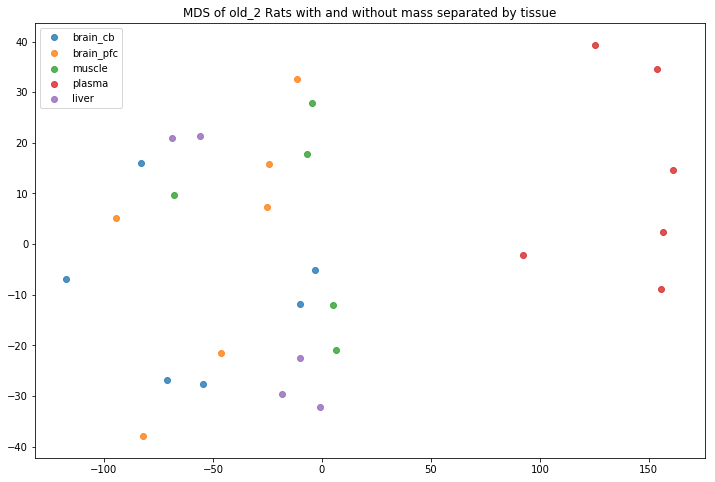

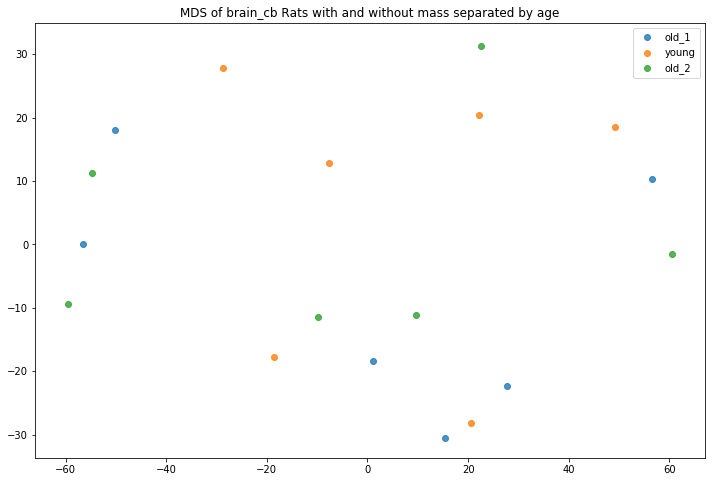

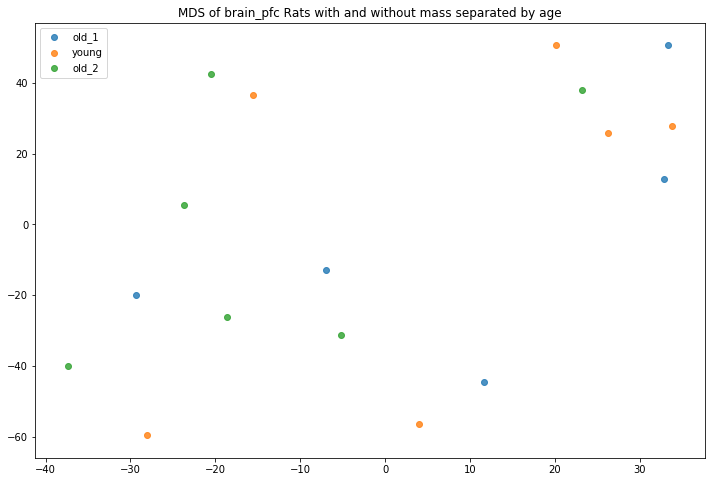

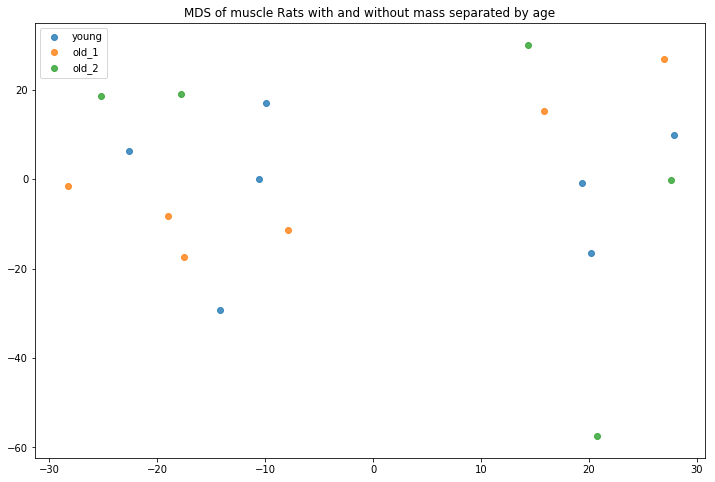

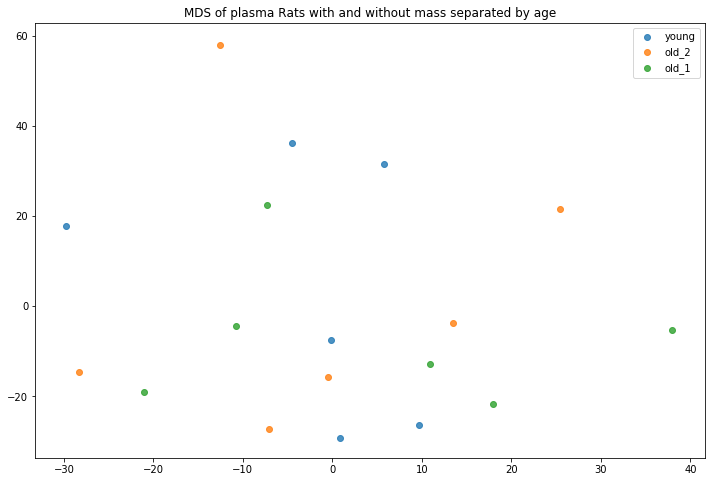

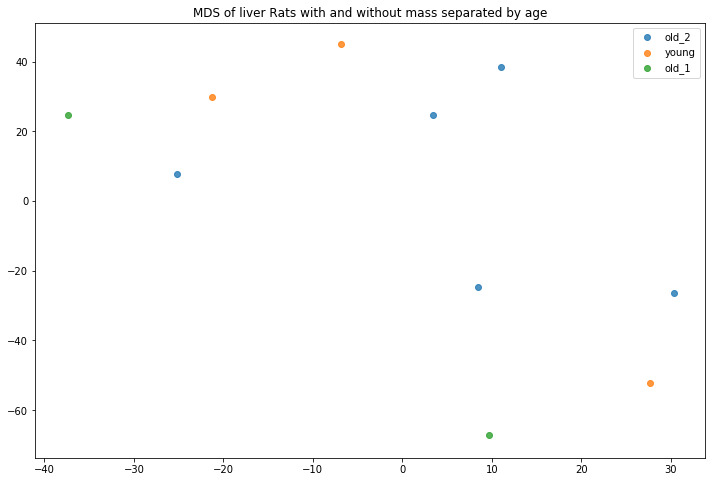

In [17]:
# Generate almost all plots with separations on tissue and age groups
analyses = ['pca', 'mds']
separation_feature = 'tissue'
feature = 'age'
species = 'rats'

for analysis in analyses:
    for with_mass in [True, False]:
        draw_for_all(df, feature, analysis, species, separation_feature, functions, {}, with_mass=with_mass)
        draw_for_all(df, separation_feature, analysis, species, feature, functions, {}, with_mass=with_mass)

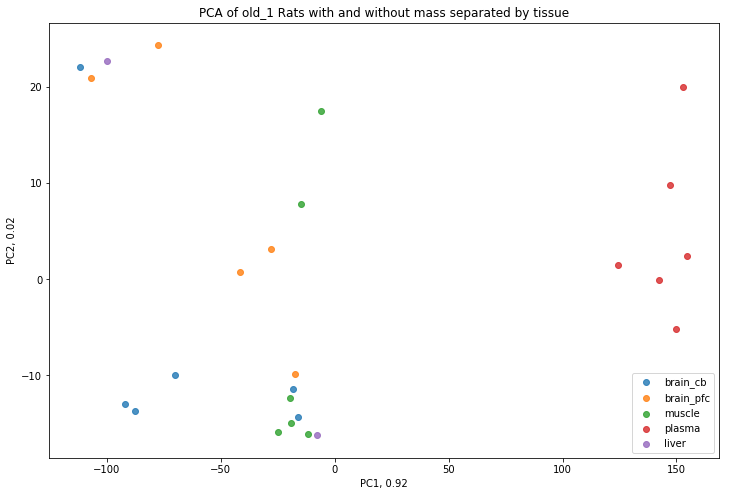

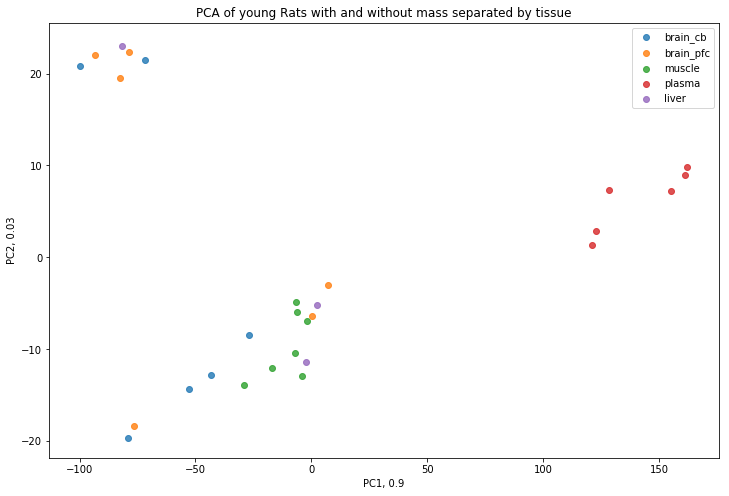

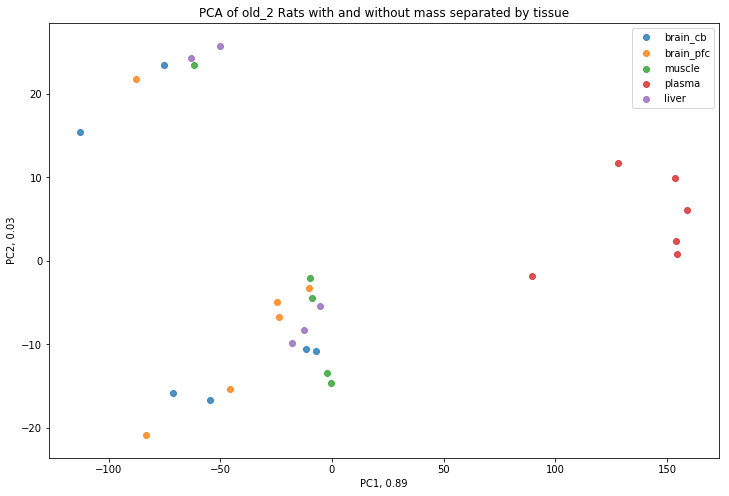

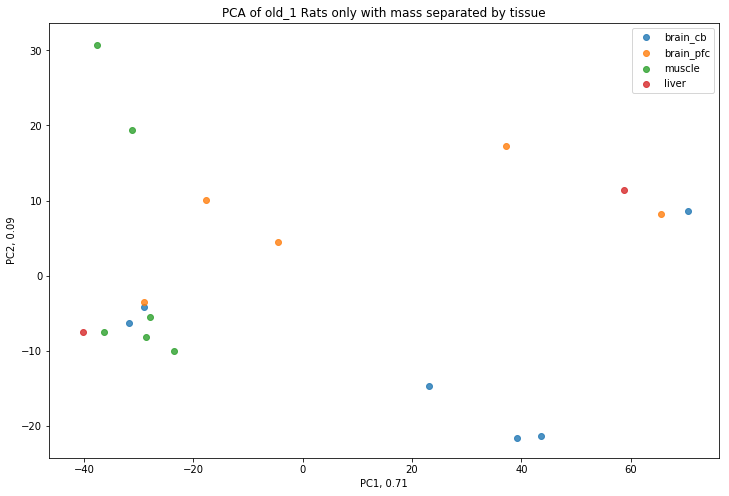

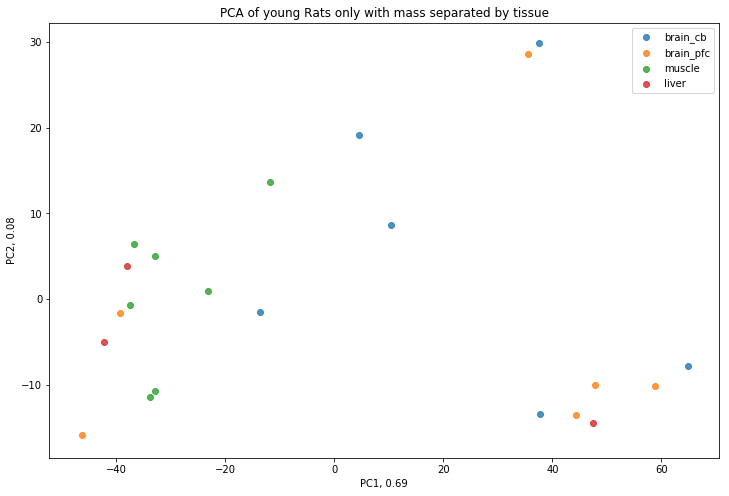

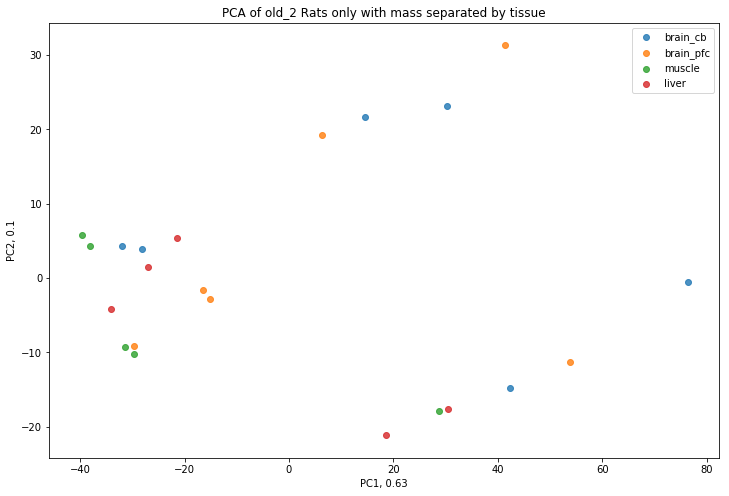

In [21]:
analysis = 'pca'
separation_feature = 'tissue'
feature = 'age'

draw_for_all(df, feature, analysis, species, separation_feature, functions, {}, with_mass=False)
draw_for_all(df, feature, analysis, species, separation_feature, functions, {}, with_mass=True)

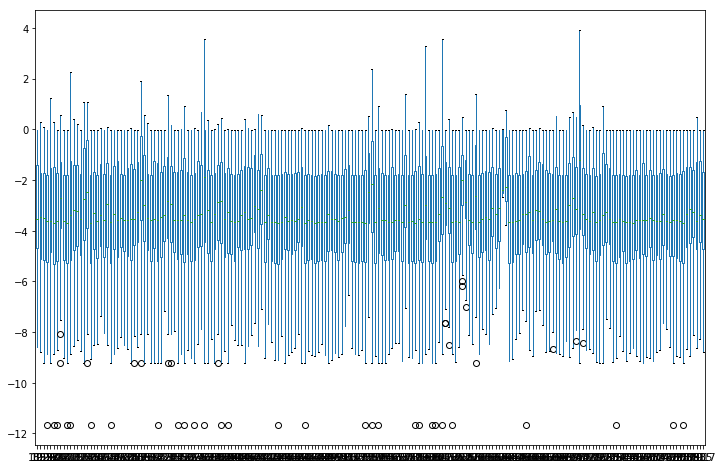

In [42]:
df.loc[df.index[:-meta], samples].iloc[0:200].astype('float').T.plot(kind='box', figsize=(12, 8))

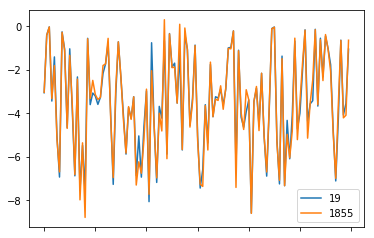

In [33]:
df.loc[df.index[:-meta], samples].iloc[0:2].T.plot()